<IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">

    
# Local grid refinement   

*O.N. Ebbens, Artesia, 2021*

This notebook shows an example of a vertex model create with the `nlmod` package.

### Contents<a name="TOC"></a>
1. [Create model](#create)
2. [Local grid refinement](#lgr)
3. [Run Model](#run)
3. [Visualise](#Visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd
import logging

import nlmod

In [2]:
print(f'nlmod version: {nlmod.__version__}')

# toon informatie bij het aanroepen van functies
logging.basicConfig(level=logging.INFO)

nlmod version: 0.1.1b


### [1. Create model](#TOC)<a name="create"></a>

Modflow 6 makes it possible to use locally refined grids. In NLmod you can use a shapefile and a number of levels to specify where and how much you want to use local grid refinement. Below we use a shapefile of the Planetenweg in IJmuiden and set the refinement levels at 2. This well create a grid with cells of 100x100m except at the Planetenweg where the cells will be refined to 25x25m. See also figures below.

In [3]:
# model settings vertex
model_ws = 'model3'
model_name = 'IJm_planeten'
refine_shp_fname = os.path.join(
    nlmod.NLMOD_DATADIR, 'shapes', 'planetenweg_ijmuiden')
levels = 2
use_cache = True
extent = [95000., 105000., 494000., 500000.]
delr = 100.
delc = 100.
steady_state = False
steady_start = True
transient_timesteps = 5
perlen = 1.
start_time = '2015-1-1'
gridtype = 'vertex'
use_regis = True
regis_botm_layer = b'MSz1'
use_geotop = True
add_northsea = True
starting_head = 1.0

In [4]:
# create model time dataset
model_ds = nlmod.mdims.get_empty_model_ds(model_name, model_ws)

# add time discretisation
model_ds = nlmod.mdims.set_model_ds_time(model_ds,
                                         start_time,
                                         steady_state,
                                         steady_start=steady_start,
                                         transient_timesteps=transient_timesteps,
                                         perlen=perlen)

# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds)

extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent,
                                                          delr,
                                                          delc)

# layer model
layer_model = nlmod.read.regis.get_combined_layer_models(extent, delr, delc,
                                                         use_regis=use_regis,
                                                         regis_botm_layer=regis_botm_layer,
                                                         use_geotop=use_geotop,
                                                         cachedir=model_ds.cachedir,
                                                         cachename='combined_layer_ds.nc')

INFO:nlmod.mfpackages.mfpackages:creating modflow SIM, TDIS, GWF and IMS
INFO:nlmod.read.regis:redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
INFO:nlmod.read.regis:new extent is [95000.0, 105000.0, 494000.0, 500000.0] model has 60 rows and 100 columns
INFO:nlmod.cache:using cached data -> combined_layer_ds.nc


### [2. Local grid refinement](#TOC)<a name="lgr"></a>

the code below applies a local grid refinement to the layer model. The local grid refinement is based on the shapefile 'planetenweg_ijmuiden.shp', which contains a line shape of the Planetenweg, and the levels, which is 2. This means that the model cells at the Planetenweg will get a size of 25 x 25m. 

In [5]:
# use gridgen to create vertex grid
model_ds.attrs['gridgen_ws'] = os.path.join(model_ws, 'gridgen')
gridprops = nlmod.mdims.create_vertex_grid(model_ds.gridgen_ws, model_name, gwf,
                                                 [(refine_shp_fname, 'line', levels)],
                                                 extent,
                                                 layer_model.dims['layer'],
                                                 nrow, ncol,
                                                 delr, delc,
                                                 cachedir=model_ds.cachedir, use_cache=use_cache)

# add layer model to vertex grid
layer_model_unstr = nlmod.mdims.get_resampled_ml_layer_ds_vertex(raw_ds=layer_model,
                                                                 extent=extent,
                                                                 gridprops=gridprops)

# combine model time dataset with layer model dataset
model_ds = nlmod.mdims.update_model_ds_from_ml_layer_ds(model_ds,
                                                        layer_model_unstr,
                                                        gridtype,
                                                        keep_vars=['x', 'y'],
                                                        gridprops=gridprops,
                                                        add_northsea=add_northsea,
                                                        cachedir=model_ds.cachedir)

# Create discretization
disv = nlmod.mfpackages.disv_from_model_ds(model_ds, gwf, gridprops)

INFO:nlmod.mdims.mgrid:using cached griddata from file model3\cache\gridprops.pklz
INFO:nlmod.mdims.resample:resample model layer data to vertex modelgrid
INFO:nlmod.mdims.mgrid:get active cells (idomain) from bottom DataArray
INFO:nlmod.mdims.mgrid:get first active modellayer for each cell in idomain
INFO:nlmod.mdims.mgrid:using top and bottom from model layers dataset for modflow model
INFO:nlmod.mdims.mgrid:replace nan values for inactive layers with dummy value
INFO:nlmod.mdims.mgrid:add kh and kv from model layer dataset to modflow model
INFO:nlmod.mdims.mgrid:nan values at the northsea are filled using the bathymetry from jarkus
INFO:nlmod.cache:cached data has same grid as current model
INFO:nlmod.cache:cached data has same time discretisation as current model
INFO:nlmod.cache:using cached data -> sea_model_ds.nc
INFO:nlmod.cache:cached data has same grid as current model
INFO:nlmod.cache:cached data has same time discretisation as current model
INFO:nlmod.cache:using cached dat

In [6]:
# create node property flow
nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.mfpackages.oc_from_model_ds(model_ds, gwf)

In [7]:
# voeg grote oppervlaktewaterlichamen toe
da_name = 'rws_oppwater'
rws_ds = nlmod.read.rws.surface_water_to_model_dataset(model_ds,
                                                       da_name,
                                                       gridprops=gridprops,
                                                       cachedir=model_ds.cachedir,
                                                       cachename=da_name)
model_ds.update(rws_ds)
ghb = nlmod.mfpackages.ghb_from_model_ds(model_ds, gwf, da_name)

# surface level drain
ahn_ds = nlmod.read.ahn.get_ahn_at_grid(model_ds, gridprops=gridprops, 
                                        cachedir=model_ds.cachedir, cachename='ahn')
model_ds.update(ahn_ds)

drn = nlmod.mfpackages.surface_drain_from_model_ds(model_ds, gwf)


# add constant head cells at model boundaries
model_ds.update(nlmod.mfpackages.constant_head.get_chd_at_model_edge(model_ds, model_ds['idomain']))    
chd = nlmod.mfpackages.chd_from_model_ds(model_ds, gwf, head='starting_head')

INFO:nlmod.cache:cached data has same grid as current model
INFO:nlmod.cache:cached data has same time discretisation as current model
INFO:nlmod.cache:using cached data -> rws_oppwater.nc
INFO:nlmod.cache:cached data has same grid as current model
INFO:nlmod.cache:cached data has same time discretisation as current model
INFO:nlmod.cache:using cached data -> ahn.nc


In [8]:
# add knmi recharge to the model datasets
knmi_ds = nlmod.read.knmi.add_knmi_to_model_dataset(model_ds, cachedir=model_ds.cachedir, cachename='recharge',
                                                     use_cache=use_cache)
model_ds.update(knmi_ds)

# create recharge package
rch = nlmod.mfpackages.rch_from_model_ds(model_ds, gwf)

INFO:nlmod.cache:cached data has same grid as current model
INFO:nlmod.cache:cached data has same time discretisation as current model
INFO:nlmod.cache:using cached data -> recharge.nc
Building ts packages rch: 100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 64.64it/s]


In [9]:
model_ds

<xarray.Dataset>
Dimensions:             (time: 6, cid: 6231, layer: 40, vert_per_cid: 4, xy: 2)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-03 ... 2015-01-05
  * cid                 (cid) int32 0 1 2 3 4 5 ... 6226 6227 6228 6229 6230
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
  * vert_per_cid        (vert_per_cid) int32 0 1 2 3
  * xy                  (xy) <U1 'x' 'y'
Data variables: (12/22)
    time_steps          (time) int32 0 1 2 3 4 5
    x                   (cid) float64 ...
    y                   (cid) float64 ...
    idomain             (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (cid) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, cid) float64 -13.07 -13.07 ... -218.2 -218.5
    ...                  ...
    rws_oppwater_cond   (cid) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    rws_oppwater_peil   (cid) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (cid) float64 nan nan nan nan ... 2.045 nan nan 0.224
    chd                 (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    recharge            (cid, time) float64 0.0006817 -0.0004 ... 0.0004 -0.0004
    rch_name            (cid) <U13 'rch_1' 'rch_1' 'rch_1' ... 'rch_2' 'rch_2'
Attributes: (12/25)
    model_name:                IJm_planeten
    mfversion:                 mf6
    model_dataset_created_on:  20211203_12:59:36
    exe_name:                  c:\users\oebbe\02_python\nlmod\nlmod\mdims\..\...
    model_ws:                  model3
    figdir:                    model3\figure
    ...                        ...
    extent:                    [95000.0, 105000.0, 494000.0, 500000.0]
    nodata:                    -999
    anisotropy:                10
    fill_value_kh:             1.0
    fill_value_kv:             0.1
    surface_drn_cond:          1000

### [3. Write and Run](#TOC)<a name="run"></a>


In [10]:
nlmod.util.write_and_run_model(gwf, model_ds, write_model_ds=True, nb_path='03_local_grid_refinement.ipynb')

INFO:nlmod.util:write script 2021120303_local_grid_refinement.ipynb to model workspace
INFO:nlmod.util:write model dataset to cache
INFO:nlmod.util:write modflow files to model workspace


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJm_planeten...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
    writing package rch...


INFO:nlmod.util:run model


    writing package ts_0...
    writing package ts_1...
    writing package ts_2...
    writing package ts_3...
FloPy is using the following  executable to run the model: c:\users\oebbe\02_python\nlmod\nlmod\mfpackages\..\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the US

### [4. Visualise](#TOC)<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
INFO:fiona.ogrext:Failed to auto identify EPSG: 7
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
INFO:fiona.ogrext:Failed to auto identify EPSG: 7
ERROR:fiona._env:PROJ: proj_identify: Cannot find proj.db
INFO:fiona.ogrext:Failed to auto identify EPSG: 7


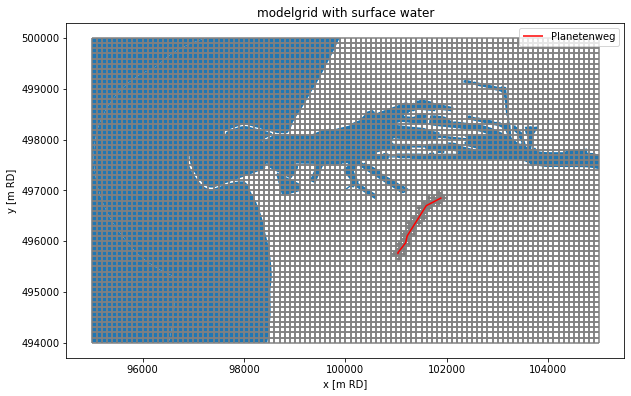

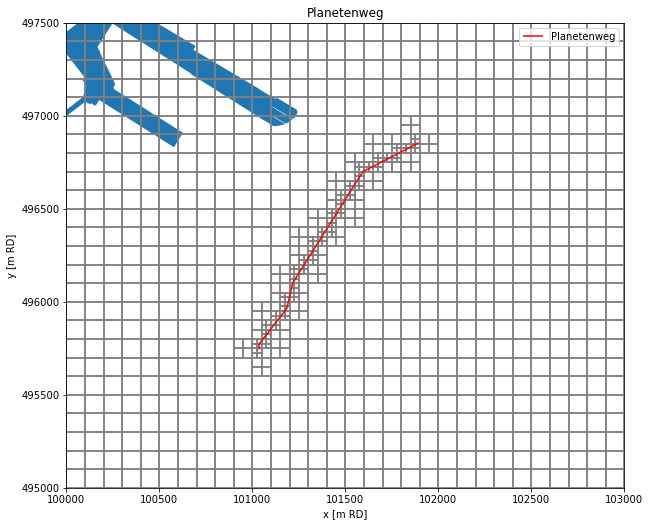

In [11]:
plan_weg_gdf = gpd.read_file(refine_shp_fname+'.shp')

# plot modelgrid
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf)
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.legend()
ax.get_figure().savefig(os.path.join(model_ds.figdir, 'mgrid_swater.png'), bbox_inches='tight')

# plot zoomed modelgrid
ax = nlmod.visualise.plots.plot_modelgrid(model_ds, gwf)
ax.set_title('Planetenweg')
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.set_xlim(100000, 103000)
ax.set_ylim(495000, 497500)
ax.legend()
ax.get_figure().savefig(os.path.join(model_ds.figdir, 'Planetenweg.png'), bbox_inches='tight')

The model dataset of a vertex model differs from a structured model dataset. The data is stored relative to the cell-id instead of the row and column number. Therefore the model dataset has the dimension cid instead of the dimensions x and y. 

In [12]:
model_ds

<xarray.Dataset>
Dimensions:             (time: 6, cid: 6231, layer: 40, vert_per_cid: 4, xy: 2)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-03 ... 2015-01-05
  * cid                 (cid) int32 0 1 2 3 4 5 ... 6226 6227 6228 6229 6230
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
  * vert_per_cid        (vert_per_cid) int32 0 1 2 3
  * xy                  (xy) <U1 'x' 'y'
Data variables: (12/22)
    time_steps          (time) int32 0 1 2 3 4 5
    x                   (cid) float64 9.505e+04 9.515e+04 ... 1.048e+05 1.05e+05
    y                   (cid) float64 5e+05 5e+05 5e+05 ... 4.94e+05 4.94e+05
    idomain             (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (cid) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, cid) float64 -13.07 -13.07 ... -218.2 -218.5
    ...                  ...
    rws_oppwater_cond   (cid) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    rws_oppwater_peil   (cid) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (cid) float64 nan nan nan nan ... 2.045 nan nan 0.224
    chd                 (layer, cid) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    recharge            (cid, time) float64 0.0006817 -0.0004 ... 0.0004 -0.0004
    rch_name            (cid) <U13 'rch_1' 'rch_1' 'rch_1' ... 'rch_2' 'rch_2'
Attributes: (12/28)
    model_name:                        IJm_planeten
    mfversion:                         mf6
    model_dataset_created_on:          20211203_12:59:36
    exe_name:                          c:\users\oebbe\02_python\nlmod\nlmod\m...
    model_ws:                          model3
    figdir:                            model3\figure
    ...                                ...
    fill_value_kh:                     1.0
    fill_value_kv:                     0.1
    surface_drn_cond:                  1000
    model_dataset_written_to_disk_on:  20211203_12:59:43
    model_data_written_to_disk_on:     20211203_12:59:48
    model_ran_on:                      20211203_12:59:57

To plot the same rasters as for the previous model we can use the `nlmod.visualise.plots.plot_vertex_array()` function.

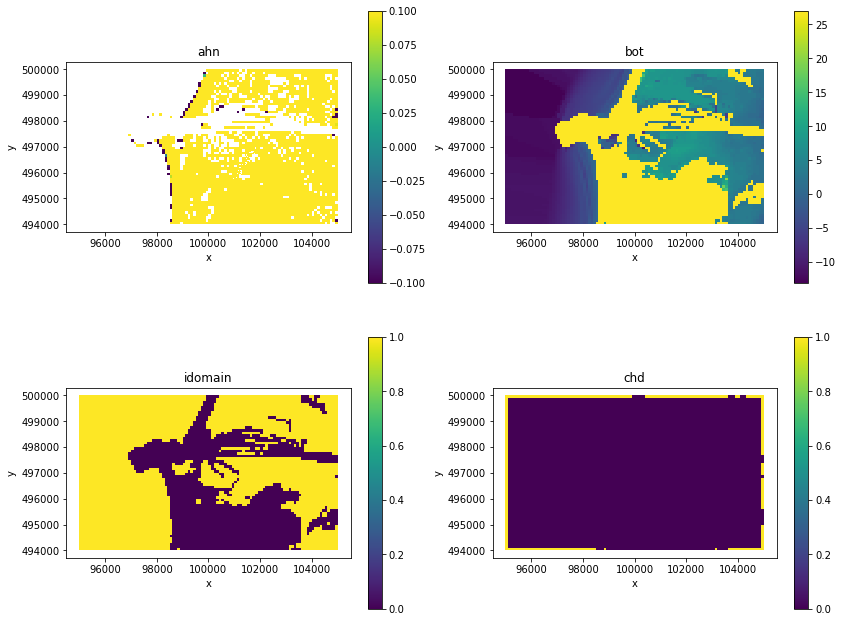

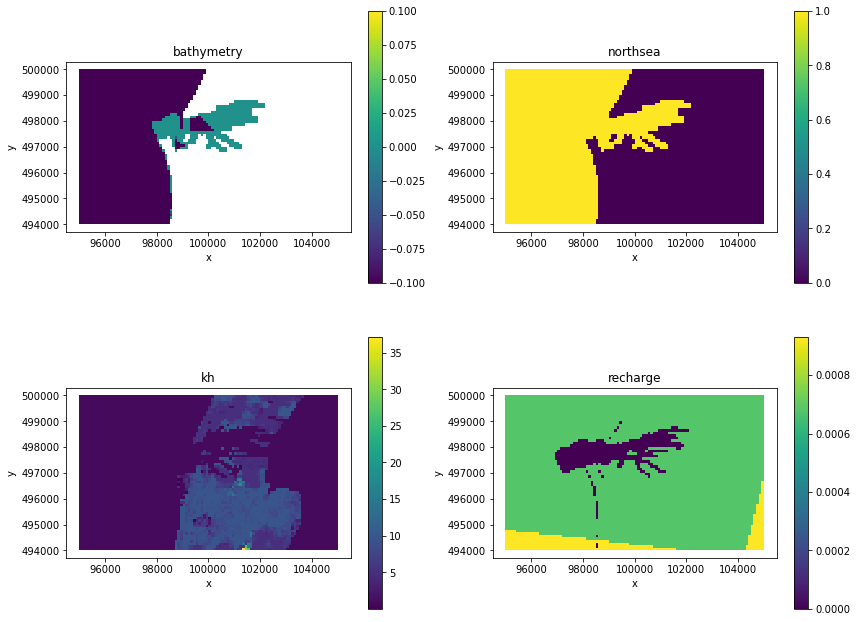

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.visualise.plots.plot_vertex_array(model_ds['ahn'], model_ds['vertices'], ax=axes[0][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['bot'][0], model_ds['vertices'], ax=axes[0][1])
nlmod.visualise.plots.plot_vertex_array(model_ds['idomain'][0], model_ds['vertices'], ax=axes[1][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['chd'][0], model_ds['vertices'], ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(model_ds.figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.visualise.plots.plot_vertex_array(model_ds['bathymetry'], model_ds['vertices'], ax=axes[0][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['northsea'], model_ds['vertices'], ax=axes[0][1])
nlmod.visualise.plots.plot_vertex_array(model_ds['kh'][1], model_ds['vertices'], ax=axes[1][0])
nlmod.visualise.plots.plot_vertex_array(model_ds['recharge'][:, 0], model_ds['vertices'], ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(model_ds.figdir, 'bath_nsea_kh_rch.png'), bbox_inches='tight')